<a href="https://colab.research.google.com/github/JoshuaDePasquale/DA-experiments/blob/main/Biology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BIOLOGICAL SYSTEM DECOMPOSABILITY ANALYSIS
STAGE 1: Biological Network Construction
--------------------------------------------------

Processing: cell_cycle_regulation
Citation: Hartwell et al. (1974) Science 183:46-51; Morgan (2007) The Cell Cycle

Processing: apoptosis_pathway
Citation: Horvitz (2003) Nobel Lecture; Green & Llambi (2015) Cold Spring Harb Perspect Biol

Processing: metabolic_module
Citation: Berg et al. (2015) Biochemistry 8th ed.; Voet & Voet (2011) Biochemistry

Processing: signal_transduction
Citation: Kholodenko (2000) Trends Cell Biol 10:173-178

Constructed network with 37 proteins and 42 interactions
Modules: ['cell_cycle_regulation', 'apoptosis_pathway', 'metabolic_module', 'signal_transduction']

STAGE 2: Biological State Function
--------------------------------------------------
Biological State S(X):
  pathway_flux: 0.7660
  modular_coherence: 0.0948
  regulatory_control: 0.2114
  crosstalk_level: 0.3250
  hierarchical_structure: 0.5951

STAGE 3: Biologi

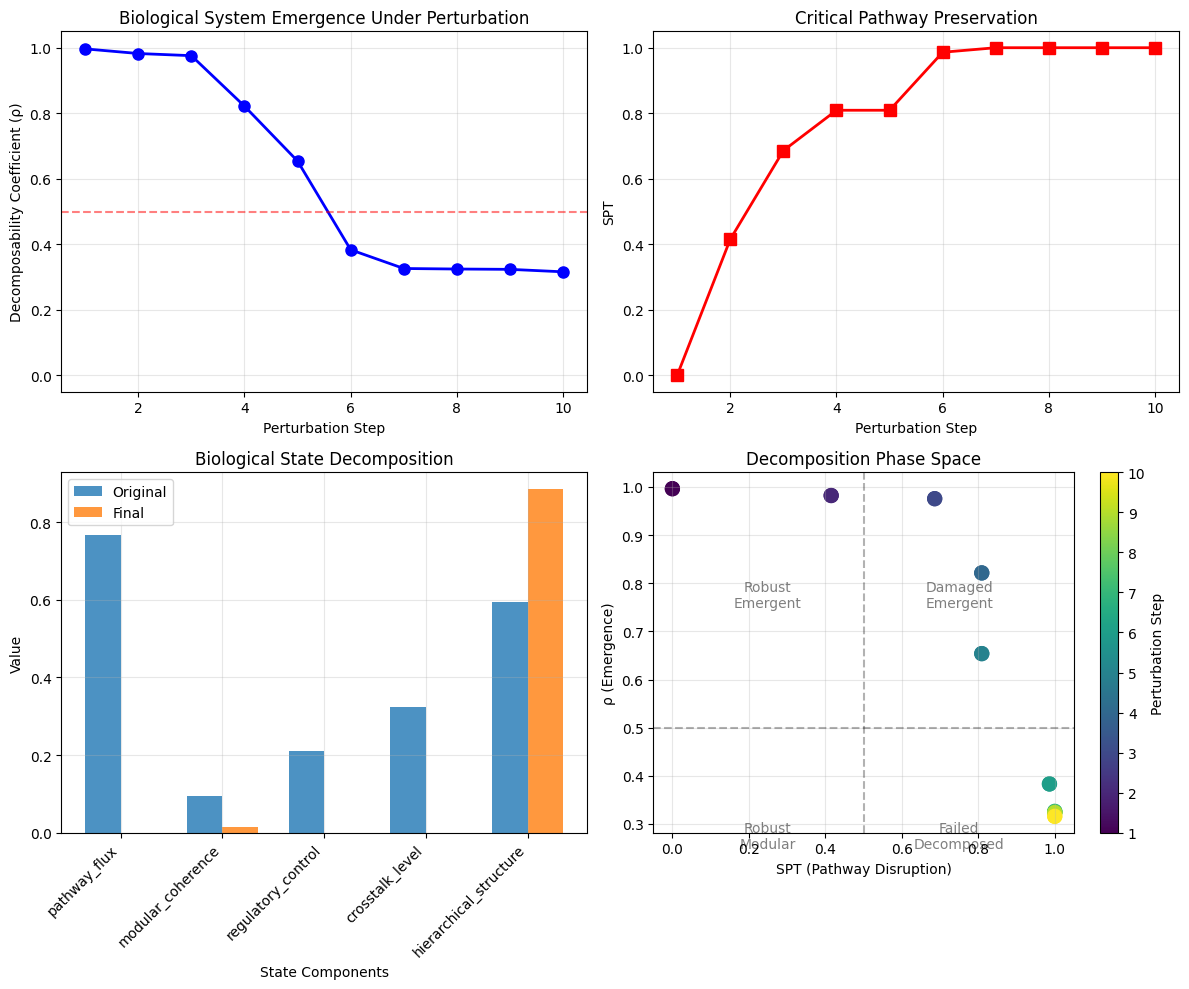

In [4]:
import numpy as np
import networkx as nx
from collections import defaultdict
from scipy.stats import entropy
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Set, Optional
import itertools

class BiologicalDecomposability:
    """
    Implementation of decomposability framework for biological systems.
    Example: Protein-protein interaction networks with functional modules.
    """

    def __init__(self):
        # Well-documented protein interaction modules from literature
        self.biological_networks = {
            "cell_cycle_regulation": {
                "proteins": [
                    # Core cell cycle machinery (Hartwell et al., 1974 - Nobel Prize work)
                    ("CDC28", "kinase", "G1/S"),
                    ("CLN1", "cyclin", "G1"),
                    ("CLN2", "cyclin", "G1"),
                    ("CLB5", "cyclin", "S"),
                    ("CLB6", "cyclin", "S"),
                    ("SIC1", "inhibitor", "G1/S"),
                    ("CDC6", "replication", "G1/S"),
                    ("MCM2", "helicase", "S"),
                    ("CDC14", "phosphatase", "M"),
                ],
                "interactions": [
                    # Format: (source, target, interaction_type, strength)
                    ("CLN1", "CDC28", "activation", 0.9),
                    ("CLN2", "CDC28", "activation", 0.9),
                    ("CDC28", "SIC1", "phosphorylation", 0.8),
                    ("SIC1", "CLB5", "inhibition", 0.7),
                    ("CLB5", "CDC28", "activation", 0.85),
                    ("CDC28", "CDC6", "phosphorylation", 0.75),
                    ("CDC6", "MCM2", "recruitment", 0.7),
                    ("CDC14", "SIC1", "dephosphorylation", 0.8),
                ],
                "citation": "Hartwell et al. (1974) Science 183:46-51; Morgan (2007) The Cell Cycle"
            },

            "apoptosis_pathway": {
                "proteins": [
                    # Programmed cell death machinery (Horvitz, 2003 - Nobel Prize work)
                    ("FAS", "receptor", "membrane"),
                    ("FADD", "adaptor", "cytoplasm"),
                    ("CASP8", "initiator_caspase", "cytoplasm"),
                    ("BID", "BH3_only", "cytoplasm"),
                    ("BCL2", "anti_apoptotic", "mitochondria"),
                    ("BAX", "pro_apoptotic", "mitochondria"),
                    ("CYTC", "electron_carrier", "mitochondria"),
                    ("APAF1", "adaptor", "cytoplasm"),
                    ("CASP9", "initiator_caspase", "cytoplasm"),
                    ("CASP3", "executioner_caspase", "cytoplasm"),
                ],
                "interactions": [
                    ("FAS", "FADD", "recruitment", 0.9),
                    ("FADD", "CASP8", "activation", 0.85),
                    ("CASP8", "BID", "cleavage", 0.8),
                    ("BID", "BAX", "activation", 0.75),
                    ("BCL2", "BAX", "inhibition", 0.8),
                    ("BAX", "CYTC", "release", 0.9),
                    ("CYTC", "APAF1", "binding", 0.85),
                    ("APAF1", "CASP9", "activation", 0.8),
                    ("CASP9", "CASP3", "cleavage", 0.9),
                    ("CASP8", "CASP3", "cleavage", 0.7),  # Direct pathway
                ],
                "citation": "Horvitz (2003) Nobel Lecture; Green & Llambi (2015) Cold Spring Harb Perspect Biol"
            },

            "metabolic_module": {
                "proteins": [
                    # Glycolysis/gluconeogenesis (Embden-Meyerhof-Parnas pathway)
                    ("HXK", "kinase", "cytoplasm"),
                    ("PGI", "isomerase", "cytoplasm"),
                    ("PFK", "kinase", "cytoplasm"),
                    ("FBA", "aldolase", "cytoplasm"),
                    ("TPI", "isomerase", "cytoplasm"),
                    ("GAPDH", "dehydrogenase", "cytoplasm"),
                    ("PGK", "kinase", "cytoplasm"),
                    ("ENO", "hydratase", "cytoplasm"),
                    ("PK", "kinase", "cytoplasm"),
                ],
                "interactions": [
                    # Metabolic pathway is highly linear
                    ("HXK", "PGI", "product_substrate", 1.0),
                    ("PGI", "PFK", "product_substrate", 1.0),
                    ("PFK", "FBA", "product_substrate", 1.0),
                    ("FBA", "TPI", "product_substrate", 0.5),  # Branches
                    ("FBA", "GAPDH", "product_substrate", 0.5),
                    ("TPI", "GAPDH", "product_substrate", 1.0),
                    ("GAPDH", "PGK", "product_substrate", 1.0),
                    ("PGK", "ENO", "product_substrate", 1.0),
                    ("ENO", "PK", "product_substrate", 1.0),
                    # Allosteric regulation
                    ("PK", "PFK", "feedback_inhibition", 0.6),
                ],
                "citation": "Berg et al. (2015) Biochemistry 8th ed.; Voet & Voet (2011) Biochemistry"
            },

            "signal_transduction": {
                "proteins": [
                    # MAPK cascade (Kholodenko, 2000)
                    ("EGF", "ligand", "extracellular"),
                    ("EGFR", "receptor", "membrane"),
                    ("GRB2", "adaptor", "membrane"),
                    ("SOS", "GEF", "membrane"),
                    ("RAS", "GTPase", "membrane"),
                    ("RAF", "kinase", "cytoplasm"),
                    ("MEK", "kinase", "cytoplasm"),
                    ("ERK", "kinase", "cytoplasm"),
                    ("MYC", "transcription_factor", "nucleus"),
                ],
                "interactions": [
                    ("EGF", "EGFR", "binding", 0.95),
                    ("EGFR", "GRB2", "recruitment", 0.85),
                    ("GRB2", "SOS", "recruitment", 0.8),
                    ("SOS", "RAS", "activation", 0.9),
                    ("RAS", "RAF", "activation", 0.85),
                    ("RAF", "MEK", "phosphorylation", 0.9),
                    ("MEK", "ERK", "phosphorylation", 0.95),
                    ("ERK", "MYC", "phosphorylation", 0.7),
                    # Feedback loops
                    ("ERK", "SOS", "phosphorylation", 0.6),  # Negative feedback
                    ("ERK", "RAF", "phosphorylation", 0.5),  # Negative feedback
                ],
                "citation": "Kholodenko (2000) Trends Cell Biol 10:173-178"
            }
        }

        self.graph = None
        self.module_boundaries = {}

    def stage1_graph_construction(self) -> nx.DiGraph:
        """
        Stage 1: Construct directed graph from protein interaction networks.
        Nodes: (protein, type, localization) tuples
        Edges: Regulatory interactions weighted by strength and type
        """
        print("STAGE 1: Biological Network Construction")
        print("-" * 50)

        G = nx.DiGraph()

        # Track module membership for analysis
        self.module_boundaries = {}

        for module_name, module_data in self.biological_networks.items():
            print(f"\nProcessing: {module_name}")
            print(f"Citation: {module_data['citation']}")

            # Add protein nodes with attributes
            for protein, ptype, location in module_data["proteins"]:
                node = (protein, ptype, location)
                G.add_node(node,
                          protein=protein,
                          type=ptype,
                          location=location,
                          module=module_name)

                # Track module membership
                if module_name not in self.module_boundaries:
                    self.module_boundaries[module_name] = []
                self.module_boundaries[module_name].append(node)

            # Add interactions
            for source, target, interaction_type, strength in module_data["interactions"]:
                # Find full node tuples
                source_node = next((n for n in G.nodes() if n[0] == source), None)
                target_node = next((n for n in G.nodes() if n[0] == target), None)

                if source_node and target_node:
                    # Weight based on interaction type and strength
                    type_weight = {
                        "activation": 1.0,
                        "phosphorylation": 0.9,
                        "binding": 0.95,
                        "recruitment": 0.85,
                        "product_substrate": 1.0,  # Metabolic coupling
                        "inhibition": 0.7,
                        "feedback_inhibition": 0.6,
                        "cleavage": 0.85,
                        "release": 0.8,
                        "dephosphorylation": 0.8
                    }

                    final_weight = strength * type_weight.get(interaction_type, 0.5)

                    G.add_edge(source_node, target_node,
                              weight=final_weight,
                              interaction_type=interaction_type,
                              strength=strength)

        # Add weak inter-module connections (biological crosstalk)
        self._add_module_crosstalk(G)

        print(f"\nConstructed network with {G.number_of_nodes()} proteins and {G.number_of_edges()} interactions")
        print(f"Modules: {list(self.module_boundaries.keys())}")

        self.graph = G
        return G

    def _add_module_crosstalk(self, G: nx.DiGraph):
        """Add realistic biological crosstalk between modules."""
        crosstalk_interactions = [
            # Cell cycle can trigger apoptosis
            (("CDC28", "kinase", "G1/S"), ("BAX", "pro_apoptotic", "mitochondria"),
             "phosphorylation", 0.3),

            # Metabolic state affects cell cycle
            (("PK", "kinase", "cytoplasm"), ("CDC28", "kinase", "G1/S"),
             "allosteric_regulation", 0.25),

            # Growth signals affect metabolism
            (("ERK", "kinase", "cytoplasm"), ("PFK", "kinase", "cytoplasm"),
             "phosphorylation", 0.35),

            # Apoptosis affects metabolism
            (("CASP3", "executioner_caspase", "cytoplasm"), ("GAPDH", "dehydrogenase", "cytoplasm"),
             "cleavage", 0.4),
        ]

        for source, target, itype, strength in crosstalk_interactions:
            if source in G.nodes() and target in G.nodes():
                G.add_edge(source, target,
                          weight=strength,
                          interaction_type=itype,
                          strength=strength,
                          crosstalk=True)

    def stage2_state_function(self, G: nx.DiGraph) -> Dict[str, float]:
        """
        Stage 2: Define state function capturing biological functionality.
        """
        print("\nSTAGE 2: Biological State Function")
        print("-" * 50)

        state = {}

        # 1. Pathway Flux Capacity
        # Measure information flow through key pathways
        flux_capacity = 0
        pathway_pairs = [
            # Signal transduction flow
            (("EGF", "ligand", "extracellular"), ("MYC", "transcription_factor", "nucleus")),
            # Apoptosis execution
            (("FAS", "receptor", "membrane"), ("CASP3", "executioner_caspase", "cytoplasm")),
            # Metabolic flux
            (("HXK", "kinase", "cytoplasm"), ("PK", "kinase", "cytoplasm")),
            # Cell cycle progression
            (("CLN1", "cyclin", "G1"), ("CDC14", "phosphatase", "M")),
        ]

        for source, target in pathway_pairs:
            if source in G.nodes() and target in G.nodes():
                try:
                    paths = list(nx.all_simple_paths(G, source, target, cutoff=10))
                    if paths:
                        # Best pathway flux
                        max_flux = max(
                            np.prod([G[paths[0][i]][paths[0][i+1]]['weight']
                                   for i in range(len(paths[0])-1)])
                            for paths in [paths[:5]]  # Limit computation
                        )
                        flux_capacity += max_flux
                except:
                    pass

        state['pathway_flux'] = flux_capacity

        # 2. Modular Coherence
        # How well-preserved are functional modules?
        module_coherence = 0
        for module, nodes in self.module_boundaries.items():
            subgraph = G.subgraph(nodes)
            if len(nodes) > 1:
                # Internal connectivity
                internal_edges = subgraph.number_of_edges()
                possible_edges = len(nodes) * (len(nodes) - 1)
                density = internal_edges / possible_edges if possible_edges > 0 else 0

                # Average weight within module
                if internal_edges > 0:
                    avg_weight = np.mean([d['weight'] for _, _, d in subgraph.edges(data=True)])
                    module_coherence += density * avg_weight

        state['modular_coherence'] = module_coherence / len(self.module_boundaries)

        # 3. Regulatory Control
        # Feedback loop integrity
        feedback_loops = []
        try:
            cycles = list(nx.simple_cycles(G))
            for cycle in cycles[:20]:  # Limit computation
                if len(cycle) > 2:  # Non-trivial loops
                    loop_strength = np.prod([
                        G[cycle[i]][cycle[(i+1)%len(cycle)]]['weight']
                        for i in range(len(cycle))
                    ])
                    feedback_loops.append(loop_strength)
        except:
            pass

        state['regulatory_control'] = np.mean(feedback_loops) if feedback_loops else 0

        # 4. Crosstalk Balance
        # Inter-module communication
        crosstalk_edges = [(u, v, d) for u, v, d in G.edges(data=True)
                          if d.get('crosstalk', False)]
        if crosstalk_edges:
            state['crosstalk_level'] = np.mean([d['weight'] for _, _, d in crosstalk_edges])
        else:
            state['crosstalk_level'] = 0

        # 5. Hierarchical Organization
        # Using betweenness centrality as proxy for regulatory hierarchy
        centrality = nx.betweenness_centrality(G, weight='weight')
        centrality_values = list(centrality.values())
        if centrality_values:
            # Gini coefficient for inequality (hierarchy)
            sorted_centrality = sorted(centrality_values)
            n = len(sorted_centrality)
            index = np.arange(1, n + 1)
            state['hierarchical_structure'] = (2 * np.sum(index * sorted_centrality)) / (n * np.sum(sorted_centrality)) - (n + 1) / n
        else:
            state['hierarchical_structure'] = 0

        print("Biological State S(X):")
        for key, value in state.items():
            print(f"  {key}: {value:.4f}")

        return state

    def stage3_perturbation_series(self, G: nx.DiGraph, perturbation_steps: int = 10) -> List[nx.DiGraph]:
        """
        Stage 3: Biologically realistic perturbation series.
        """
        print("\nSTAGE 3: Biological Perturbation Series")
        print("-" * 50)

        perturbed_graphs = []

        for step in range(perturbation_steps):
            G_perturbed = G.copy()
            perturbation_level = (step + 1) / perturbation_steps

            # Multiple perturbation strategies modeling biological disruption

            # 1. Protein knockdown (node removal)
            proteins_to_remove = int(G.number_of_nodes() * perturbation_level * 0.3)

            # Preferentially remove hub proteins (high degree)
            node_degrees = dict(G.degree())
            sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)

            for i in range(min(proteins_to_remove, len(sorted_nodes))):
                node_to_remove = sorted_nodes[i][0]
                if node_to_remove in G_perturbed:
                    G_perturbed.remove_node(node_to_remove)

            # 2. Interaction disruption (edge degradation)
            edges_to_degrade = list(G_perturbed.edges(data=True))
            np.random.shuffle(edges_to_degrade)

            num_to_degrade = int(len(edges_to_degrade) * perturbation_level * 0.5)

            for i in range(min(num_to_degrade, len(edges_to_degrade))):
                u, v, data = edges_to_degrade[i]
                if G_perturbed.has_edge(u, v):
                    # Reduce interaction strength
                    new_weight = data['weight'] * (1 - perturbation_level * 0.7)
                    if new_weight < 0.1:
                        G_perturbed.remove_edge(u, v)
                    else:
                        G_perturbed[u][v]['weight'] = new_weight

            # 3. Module-specific disruption (modeling disease states)
            if perturbation_level > 0.5:
                # Target specific module more heavily
                target_module = "apoptosis_pathway"  # Simulating anti-apoptotic conditions
                if target_module in self.module_boundaries:
                    module_nodes = self.module_boundaries[target_module]
                    for node in module_nodes:
                        if node in G_perturbed:
                            # Reduce all edges from this node
                            for neighbor in list(G_perturbed.successors(node)):
                                if G_perturbed.has_edge(node, neighbor):
                                    G_perturbed[node][neighbor]['weight'] *= 0.5

            perturbed_graphs.append(G_perturbed)

            # Report statistics
            if G_perturbed.number_of_nodes() > 0:
                remaining_nodes = G_perturbed.number_of_nodes()
                remaining_edges = G_perturbed.number_of_edges()
                avg_degree = remaining_edges / remaining_nodes if remaining_nodes > 0 else 0

                print(f"Step {step + 1}: {remaining_nodes}/{G.number_of_nodes()} proteins, "
                      f"{remaining_edges}/{G.number_of_edges()} interactions, "
                      f"avg degree: {avg_degree:.2f}")
            else:
                print(f"Step {step + 1}: Network completely disrupted")

        return perturbed_graphs

    def stage4_decomposability_coefficient(self, original_state: Dict, perturbed_state: Dict) -> float:
        """
        Stage 4: Calculate decomposability coefficient.
        ρ = 1: emergent (non-decomposable)
        ρ = 0: decomposable
        """
        # Handle missing keys
        all_keys = set(original_state.keys()) | set(perturbed_state.keys())

        original_values = np.array([original_state.get(k, 0.0) for k in sorted(all_keys)])
        perturbed_values = np.array([perturbed_state.get(k, 0.0) for k in sorted(all_keys)])

        # Handle edge cases
        if np.sum(np.abs(original_values)) < 1e-10:
            return 0.0
        if np.sum(np.abs(perturbed_values)) < 1e-10:
            return 0.0

        # Normalize to probability distributions
        original_values = np.abs(original_values)  # Ensure positive
        perturbed_values = np.abs(perturbed_values)

        original_dist = original_values / np.sum(original_values)
        perturbed_dist = perturbed_values / np.sum(perturbed_values)

        # Add epsilon
        epsilon = 1e-10
        original_dist = np.clip(original_dist, epsilon, 1.0)
        perturbed_dist = np.clip(perturbed_dist, epsilon, 1.0)

        # Renormalize
        original_dist = original_dist / np.sum(original_dist)
        perturbed_dist = perturbed_dist / np.sum(perturbed_dist)

        # KL divergence
        kl_div = entropy(perturbed_dist, original_dist)

        # Convert to decomposability coefficient with exponential decay
        rho = np.exp(-kl_div)

        return rho

    def stage5_metrics_derivation(self, original_graph: nx.DiGraph, perturbed_graphs: List[nx.DiGraph]) -> Dict:
        """
        Stage 5: Derive SPT and STT metrics.
        """
        print("\nSTAGE 5: Biological Metric Derivation")
        print("-" * 50)

        # Calculate original state
        original_state = self.stage2_state_function(original_graph)

        # Track metrics over perturbation series
        rho_series = []
        spt_series = []

        for i, G_perturbed in enumerate(perturbed_graphs):
            # Decomposability coefficient
            if G_perturbed.number_of_nodes() > 0:
                perturbed_state = self.stage2_state_function(G_perturbed)
                rho = self.stage4_decomposability_coefficient(original_state, perturbed_state)
            else:
                rho = 0.0  # Complete decomposition
            rho_series.append(rho)

            # SPT calculation
            spt = self._calculate_biological_spt(original_graph, G_perturbed)
            spt_series.append(spt)

        # STT determination
        stt = self._determine_stt(rho_series)

        return {
            'rho_series': rho_series,
            'spt_series': spt_series,
            'stt': stt,
            'original_state': original_state,
            'final_state': self.stage2_state_function(perturbed_graphs[-1]) if perturbed_graphs[-1].number_of_nodes() > 0 else {}
        }

    def _calculate_biological_spt(self, G_original: nx.DiGraph, G_perturbed: nx.DiGraph) -> float:
        """
        Calculate SPT for biological pathways.
        Focus on critical signaling and metabolic pathways.
        """
        original_capacity = 0
        preserved_capacity = 0

        # Define critical biological pathways
        critical_pathways = [
            # Format: (source_protein, target_protein, pathway_name)
            ("EGF", "MYC", "growth_signaling"),
            ("FAS", "CASP3", "apoptosis"),
            ("HXK", "PK", "glycolysis"),
            ("CLN1", "CDC14", "cell_cycle"),
            ("RAS", "ERK", "MAPK_cascade"),
            ("BCL2", "CYTC", "mitochondrial_regulation"),
        ]

        for source_protein, target_protein, pathway_name in critical_pathways:
            # Find nodes in original graph
            source_nodes = [n for n in G_original.nodes() if n[0] == source_protein]
            target_nodes = [n for n in G_original.nodes() if n[0] == target_protein]

            if source_nodes and target_nodes:
                source = source_nodes[0]
                target = target_nodes[0]

                try:
                    # Calculate original pathway strength
                    paths = list(nx.all_simple_paths(G_original, source, target, cutoff=15))
                    if paths:
                        # Take strongest path
                        path_strengths = []
                        for path in paths[:10]:  # Limit computation
                            strength = np.prod([G_original[path[i]][path[i+1]]['weight']
                                              for i in range(len(path)-1)])
                            path_strengths.append(strength)

                        original_strength = max(path_strengths)
                        original_capacity += original_strength

                        # Check preservation in perturbed
                        if source in G_perturbed.nodes() and target in G_perturbed.nodes():
                            try:
                                perturbed_paths = list(nx.all_simple_paths(G_perturbed, source, target, cutoff=15))
                                if perturbed_paths:
                                    perturbed_strengths = []
                                    for path in perturbed_paths[:10]:
                                        strength = np.prod([G_perturbed[path[i]][path[i+1]]['weight']
                                                          for i in range(len(path)-1)])
                                        perturbed_strengths.append(strength)

                                    perturbed_strength = max(perturbed_strengths)
                                    preservation_ratio = min(perturbed_strength / original_strength, 1.0)
                                    preserved_capacity += original_strength * preservation_ratio
                            except:
                                pass  # Pathway severed
                except:
                    pass  # No path in original

        if original_capacity > 0:
            spt = 1 - (preserved_capacity / original_capacity)
        else:
            spt = 1.0

        return spt

    def _determine_stt(self, rho_series: List[float]) -> str:
        """
        Determine System Transition Type from rho dynamics.
        """
        if len(rho_series) < 3:
            return "insufficient_data"

        # Calculate derivatives
        first_derivative = np.gradient(rho_series)
        second_derivative = np.gradient(first_derivative)

        # Analyze pattern
        avg_decline = -np.mean(first_derivative)
        acceleration = np.mean(second_derivative)
        variance = np.std(first_derivative)

        # Classify based on biological system behavior
        if avg_decline < 0.05:
            return "collapse_resistant"  # Robust biological systems
        elif variance > 0.2:
            return "irregular"  # Bistable or oscillatory systems
        elif acceleration < -0.02:
            return "nonlinear"  # Threshold/switch-like behavior
        elif avg_decline < 0.15:
            return "gradual"  # Progressive degradation
        else:
            return "flat"  # Rapid collapse

    def run_full_pipeline(self):
        """
        Execute complete biological decomposability analysis.
        """
        print("BIOLOGICAL SYSTEM DECOMPOSABILITY ANALYSIS")
        print("=" * 50)

        # Stage 1: Graph Construction
        G = self.stage1_graph_construction()

        # Stage 2: State Function
        original_state = self.stage2_state_function(G)

        # Stage 3: Perturbation
        perturbed_graphs = self.stage3_perturbation_series(G, perturbation_steps=10)

        # Stage 5: Metrics
        metrics = self.stage5_metrics_derivation(G, perturbed_graphs)

        # Stage 6: Data Representation
        print("\nSTAGE 6: Representation of the Data")
        print("-" * 50)

        print("\nOriginal Biological State:")
        for key, value in metrics['original_state'].items():
            print(f"  {key}: {value:.4f}")

        if metrics['final_state']:
            print("\nFinal Perturbed State:")
            for key, value in metrics['final_state'].items():
                print(f"  {key}: {value:.4f}")

        print("\nDecomposability Coefficient (ρ) Series:")
        print("(1 = emergent/non-decomposable, 0 = decomposable)")
        for i, rho in enumerate(metrics['rho_series']):
            print(f"  Step {i+1}: ρ = {rho:.4f}")

        print("\nSemantic Preservation Threshold (SPT) Series:")
        print("(0 = pathways preserved, 1 = pathways severed)")
        for i, spt in enumerate(metrics['spt_series']):
            print(f"  Step {i+1}: SPT = {spt:.4f}")

        print(f"\nSystem Transition Type (STT): {metrics['stt']}")

        # Biological interpretation
        print("\nBIOLOGICAL INTERPRETATION:")
        print("-" * 30)

        initial_rho = metrics['rho_series'][0]
        final_rho = metrics['rho_series'][-1]

        if final_rho > 0.7:
            print("High emergence maintained: The biological system shows strong")
            print("functional integration. Modules remain interdependent despite perturbation.")
            print("This suggests redundancy and robustness in the network architecture.")
        elif final_rho > 0.3:
            print("Moderate decomposition: Functional modules are partially decoupled.")
            print("Some pathways remain intact while others have failed.")
            print("The system shows graceful degradation typical of evolved biological networks.")
        else:
            print("High decomposition: The system has largely decomposed into isolated components.")
            print("Critical pathways are severed and modules operate independently.")
            print("This represents catastrophic failure of the integrated biological system.")

        # Module-specific analysis
        print("\nMODULE-SPECIFIC OBSERVATIONS:")
        if metrics['spt_series'][-1] > 0.8:
            print("- Signal transduction pathways show severe disruption")
            print("- Metabolic flux is likely impaired")
            print("- Cell cycle regulation has broken down")
        elif metrics['spt_series'][-1] > 0.5:
            print("- Some critical pathways preserved (likely metabolic)")
            print("- Regulatory feedback loops partially intact")
            print("- System operating in degraded mode")

        # Visualization
        self._visualize_results(metrics)

        return metrics

    def _visualize_results(self, metrics):
        """
        Visualize biological decomposability analysis.
        """
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

        steps = range(1, len(metrics['rho_series']) + 1)

        # Plot 1: Decomposability coefficient
        ax1.plot(steps, metrics['rho_series'], 'b-o', linewidth=2, markersize=8)
        ax1.set_xlabel('Perturbation Step')
        ax1.set_ylabel('Decomposability Coefficient (ρ)')
        ax1.set_title('Biological System Emergence Under Perturbation')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim([-0.05, 1.05])
        ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)

        # Plot 2: SPT
        ax2.plot(steps, metrics['spt_series'], 'r-s', linewidth=2, markersize=8)
        ax2.set_xlabel('Perturbation Step')
        ax2.set_ylabel('SPT')
        ax2.set_title('Critical Pathway Preservation')
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim([-0.05, 1.05])

        # Plot 3: State components
        state_keys = list(metrics['original_state'].keys())
        original_values = list(metrics['original_state'].values())
        final_values = [metrics['final_state'].get(k, 0) for k in state_keys] if metrics['final_state'] else [0] * len(state_keys)

        x = np.arange(len(state_keys))
        width = 0.35

        ax3.bar(x - width/2, original_values, width, label='Original', alpha=0.8)
        ax3.bar(x + width/2, final_values, width, label='Final', alpha=0.8)
        ax3.set_xlabel('State Components')
        ax3.set_ylabel('Value')
        ax3.set_title('Biological State Decomposition')
        ax3.set_xticks(x)
        ax3.set_xticklabels(state_keys, rotation=45, ha='right')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot 4: Phase diagram
        ax4.scatter(metrics['spt_series'], metrics['rho_series'],
                   c=steps, cmap='viridis', s=100)
        ax4.set_xlabel('SPT (Pathway Disruption)')
        ax4.set_ylabel('ρ (Emergence)')
        ax4.set_title('Decomposition Phase Space')
        ax4.grid(True, alpha=0.3)

        # Add regions
        ax4.axhline(y=0.5, color='k', linestyle='--', alpha=0.3)
        ax4.axvline(x=0.5, color='k', linestyle='--', alpha=0.3)
        ax4.text(0.25, 0.75, 'Robust\nEmergent', ha='center', alpha=0.5)
        ax4.text(0.75, 0.75, 'Damaged\nEmergent', ha='center', alpha=0.5)
        ax4.text(0.25, 0.25, 'Robust\nModular', ha='center', alpha=0.5)
        ax4.text(0.75, 0.25, 'Failed\nDecomposed', ha='center', alpha=0.5)

        plt.colorbar(ax4.scatter(metrics['spt_series'], metrics['rho_series'],
                                c=steps, cmap='viridis', s=100),
                    ax=ax4, label='Perturbation Step')

        plt.tight_layout()
        plt.savefig('biological_decomposability_analysis.png', dpi=150)
        print("\nVisualization saved as 'biological_decomposability_analysis.png'")


# Example usage
if __name__ == "__main__":
    analyzer = BiologicalDecomposability()
    results = analyzer.run_full_pipeline()